## 청라, 송도지역 미세먼지 측정값 스크래핑
> 1. 송도 = https://bit.ly/2EWi9vM
> 1. 청라 = https://bit.ly/2Al7h6y

* Todo: 계측 센서 갯수가 다르므로 필터링 방식이 달라져야 한다
* 송도 = 6개 / 청라 = 4개

In [1]:
"""
* 청라, 송도지역 미세먼지 측정값 스크래핑
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

In [2]:
URLS = [
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999991',
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999992',
]

""" 주의!: 송도와 청라는 데이터 갯수가 틀려서 필터링 방법을 달리해야 함. """
URL = URLS[0]  # 0=청라 - 측정치 1+3 = 4개
URL = URLS[1]  # 1=송도 - 측정치 1+6 = 7개

RESPONSE = requests.get(URL)
SOUP = BeautifulSoup(RESPONSE.content, 'html.parser')
TABLE = SOUP.find_all('table', {'class': 'view'})

TDS = TABLE[0].find_all('td')
FONTS = TABLE[0].find_all('font')
SPANS = TABLE[0].find_all('span')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [3]:
TDS    # <td class="txt_right"><span tabindex="0"> 2018년<br/>12월 30일<br/>02시</span></td>, ...모든 데이터
FONTS   # <font color="black">0.005</font>,... <font color="black">11</font>, ... 센서값 7개씩 반복
SPANS

[<span tabindex="0">시간</span>,
 <span tabindex="0">측정항목</span>,
 <span tabindex="0">SO<sub>2</sub>(ppm)</span>,
 <span tabindex="0">NO<sub>2</sub>(ppm)</span>,
 <span tabindex="0">O<sub>3</sub>(ppm)</span>,
 <span tabindex="0">CO(ppm)</span>,
 <span tabindex="0">PM<sub>10</sub><br/>(㎍/㎥)</span>,
 <span tabindex="0">PM<sub>2.5</sub><br/>(㎍/㎥)</span>,
 <span tabindex="0">
 2018년<br/>12월 30일<br/>19시</span>,
 <span tabindex="0">
 <font color="black">0.006</font></span>,
 <span tabindex="0">
 <font color="black">0.024</font> </span>,
 <span tabindex="0">
 <font color="black">0.021</font> </span>,
 <span tabindex="0">
 <font color="black">0.6</font> </span>,
 <span tabindex="0">
 <font color="black">32</font> </span>,
 <span tabindex="0">
 <font color="black">18</font> </span>,
 <span tabindex="0">
 18시</span>,
 <span tabindex="0">
 <font color="black">0.006</font></span>,
 <span tabindex="0">
 <font color="black">0.023</font> </span>,
 <span tabindex="0">
 <font color="black">0.022</font> <

## 데이터의 길이를 기준으로 구분한다 (EDA)
> 12자 길이를 넘어가는 데이터는 한글 테이터이다.

In [4]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()
# print(neat_span)              # 값 확인해 봄!

In [5]:
DATA = []
DATE = []

for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()

    if len(neat_span) > 12:                           # 2018년12월 29일24시
        """ 날짜와 시간을 분리해서 각각 넣는다 """
        DATE.append(neat_span[:-3])     # 날짜 = 2018년 12월 29일
        DATA.append(neat_span[-3:])     # 시간 = '24시'  .. 날짜는 잘라내고, 시간만 넣는다
    else:
        DATA.append(neat_span)          # 그렇지 않으면 그냥 넣는다

In [6]:
""" 리스트에 담긴 해당 날짜를 보여준다, 그래봤자 2개 지만.. """
print(DATE[0])                          # 2018년12월 30일  ... 오늘날짜가 먼저 담긴다.
print(DATE[1])                          # 2018년12월 29일  ... 어제날짜가 다음에 담긴다.

2018년12월 30일
2018년12월 29일


In [7]:
""" 데이터가 7줄씩 한줄로 쌓인다.  확인해 보자 """
DATA    # ['시간','측정항목','SO2(ppm)','NO2(ppm)','O3(ppm)','CO(ppm)','PM10(㎍/㎥)','PM2.5(㎍/㎥)',
FULL_COLUMNS = ['Time(24Hr)',]
FULL_COLUMNS.extend(DATA[2:8])
FULL_COLUMNS

['Time(24Hr)',
 'SO2(ppm)',
 'NO2(ppm)',
 'O3(ppm)',
 'CO(ppm)',
 'PM10(㎍/㎥)',
 'PM2.5(㎍/㎥)']

In [8]:
COLUMNS = []
UNIT = []

for item in FULL_COLUMNS:      # full 컬럼값에서 '타이틀'과 '단위'를 분리해 냄
    title = item.split('(')[0]    # Title
    _rest = item.split('(')[1]
    
    COLUMNS.append(title)
    UNIT.append(_rest[:-1])

# (['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
#  ['24Hr', 'ppm', 'ppm', 'ppm', 'ppm', '㎍/㎥', '㎍/㎥'])    
COLUMNS, UNIT

(['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
 ['24Hr', 'ppm', 'ppm', 'ppm', 'ppm', '㎍/㎥', '㎍/㎥'])

In [9]:
CUT_DATA = DATA[8:]                       # 앞부분을 잘라내고 데이터부분만 남김 =  1-DIM
DATA_NP = np.array(CUT_DATA)              # numpy 데이터 변환!
DATA_NP2D = np.reshape(DATA_NP, (-1,7))   # 1D to 2D 변환 (-1,7)
np.shape(a=DATA_NP2D)                     # (26,7)

(43, 7)

In [10]:
DATA_NP2D[25]           # 가로행 = array(['01시', '0.005', '0.010', '0.028', '0.4', '27', '10'], dtype='<U5')
DATA_NP2D[:,0]          # 컬럼만 = array(['02시', '01시', '24시

array(['19시', '18시', '17시', '16시', '15시', '14시', '13시', '12시', '11시',
       '10시', '09시', '08시', '07시', '06시', '05시', '04시', '03시', '02시',
       '01시', '24시', '23시', '22시', '21시', '20시', '19시', '18시', '17시',
       '16시', '15시', '14시', '13시', '12시', '11시', '10시', '09시', '08시',
       '07시', '06시', '05시', '04시', '03시', '02시', '01시'], dtype='<U5')

In [11]:
TIME_COL = DATA_NP2D[:,0]                         # 시간열만 쪼개서 따로 담음
DATA_NP2D[:,0] = [time[:2] for time in TIME_COL]  # 02시 --> 02, 앞 두글자만 잘라냄

In [12]:
DATA_NP2D[:5,]

array([['19', '0.006', '0.024', '0.021', '0.6', '32', '18'],
       ['18', '0.006', '0.023', '0.022', '0.5', '38', '20'],
       ['17', '0.007', '0.024', '0.022', '0.6', '39', '22'],
       ['16', '0.007', '0.019', '0.026', '0.5', '41', '20'],
       ['15', '0.008', '0.018', '0.026', '0.5', '38', '20']], dtype='<U5')

In [13]:
# DATA_NP2D (String) 은 원본으로 남겨두고, Float 숫자로 변환하여 AIR_DATA_NP로 변경 
# AIR_DATA_NP = np.asfarray(DATA_NP2D, dtype=np.float)  # 문자열 --> float 로 변경해 줌(1)
AIR_DATA_NP = DATA_NP2D.astype(np.float64)            # 문자열 --> float 로 변경해 줌(2)

AIR_DATA_NP[:5,]

array([[1.9e+01, 6.0e-03, 2.4e-02, 2.1e-02, 6.0e-01, 3.2e+01, 1.8e+01],
       [1.8e+01, 6.0e-03, 2.3e-02, 2.2e-02, 5.0e-01, 3.8e+01, 2.0e+01],
       [1.7e+01, 7.0e-03, 2.4e-02, 2.2e-02, 6.0e-01, 3.9e+01, 2.2e+01],
       [1.6e+01, 7.0e-03, 1.9e-02, 2.6e-02, 5.0e-01, 4.1e+01, 2.0e+01],
       [1.5e+01, 8.0e-03, 1.8e-02, 2.6e-02, 5.0e-01, 3.8e+01, 2.0e+01]])

In [14]:
# Pandas DataFrame 오브젝트로 변경한다.
# df.index = df.Time      # 인덱스를 타임으로 변경함  .... 인덱스는 UID 중복 불가함(에러)

# df = df.drop('column_name', 1)
# where 1 is the axis number (0 for rows and 1 for columns.)
# df = df.drop('Time', 1) # 1=axis (column) / 0=rows  .... 1컬럼을 삭제하는 방법

df = pd.DataFrame(AIR_DATA_NP, columns=COLUMNS)
df.head(n=5)

,Time,SO2,NO2,O3,CO,PM10,PM2.5
0,19.0,0.006,0.024,0.021,0.6,32.0,18.0
1,18.0,0.006,0.023,0.022,0.5,38.0,20.0
2,17.0,0.007,0.024,0.022,0.6,39.0,22.0
3,16.0,0.007,0.019,0.026,0.5,41.0,20.0
4,15.0,0.008,0.018,0.026,0.5,38.0,20.0


In [35]:
df.Time.astype(dtype=np.str).head()
TIME_COL

array(['19', '18', '17', '16', '15', '14', '13', '12', '11', '10', '09',
       '08', '07', '06', '05', '04', '03', '02', '01', '24', '23', '22',
       '21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11',
       '10', '09', '08', '07', '06', '05', '04', '03', '02', '01'],
      dtype='<U5')

In [15]:
# 그래프 함수의 정의

def df_plot(df_column):
    plt.plot(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("HISTOGRAM - DISTRIBUTION")        # 타이틀
    plt.xlabel('x label')           # x 라벨
    plt.ylabel('y label')           # y 라벨
    plt.legend()
    plt.xticks(df.index.values, df.Time)
    
def df_hist(df_column):
    plt.hist(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("HISTOGRAM - DISTRIBUTION")        # 타이틀
    plt.xlabel('x label')           # x 라벨
    plt.ylabel('y label')           # y 라벨
    
    
def df_scatter(df_col1, df_col2):
    plt.scatter(df_col1, df_col2,alpha=0.2)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("HISTOGRAM - DISTRIBUTION")        # 타이틀
    plt.xlabel('x label')           # x 라벨
    plt.ylabel('y label')           # y 라벨    

def df_flip_x():
    plt.gca().invert_xaxis()

def df_flip_y():
    plt.gca().invert_yaxis()
    
def df_flip_all():
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
def plot_2charts(data_series, xlabel):  
    """
    # 히스토그램 + 박스플롯을 4x4화면 윗쪽 2개로 플롯해줍니다.
    """
    plt.figure()
    plt.subplot(221)
    plt.hist(data_series)
    plt.xlabel(xlabel)
    
    plt.subplot(222)
    sns.boxplot(data_series)
    plt.show()    

## 전체 센서값 동향 플로팅
 ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

In [16]:
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO']]
# plt.show()
type(df.CO)         # pandas.core.series.Series


# df 에 'NEW'칼럼 추가하기 (df.CO값을 복사해서 칸을 늘림)
df['CO_mod'] = pd.Series(df.CO.copy(), index=df.index)
df.head()

,Time,SO2,NO2,O3,CO,PM10,PM2.5,CO_mod
0,19.0,0.006,0.024,0.021,0.6,32.0,18.0,0.6
1,18.0,0.006,0.023,0.022,0.5,38.0,20.0,0.5
2,17.0,0.007,0.024,0.022,0.6,39.0,22.0,0.6
3,16.0,0.007,0.019,0.026,0.5,41.0,20.0,0.5
4,15.0,0.008,0.018,0.026,0.5,38.0,20.0,0.5


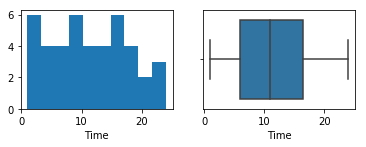

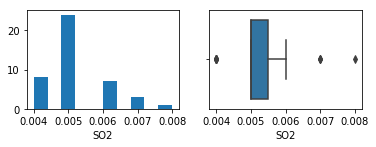

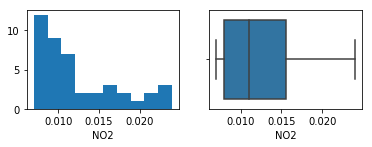

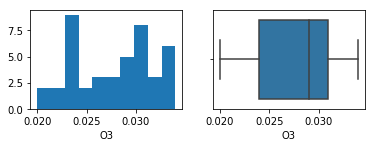

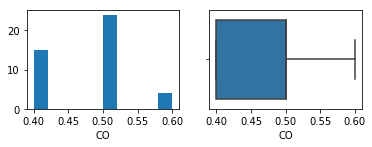

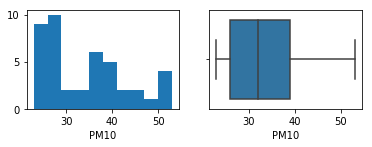

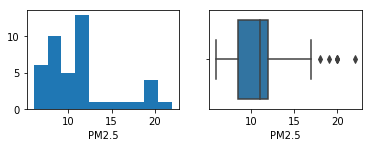

In [17]:
for item in COLUMNS:
    plot_2charts(data_series=df[item], xlabel=item)

In [18]:
# 'NEW' 칼럼의 값을 절반으로 변경   ... 반복실행할때 마다 값이 줄어 듬
# df.NEW = df.NEW/2
# df.head(5)

# CO값 차이가 커서,(9로 나눠서 한 그래프에 표시)..['SO2', 'NO2', 'O3', 'CO_mod',]
df.CO_mod = df.CO_mod/9
df.head(5)

,Time,SO2,NO2,O3,CO,PM10,PM2.5,CO_mod
0,19.0,0.006,0.024,0.021,0.6,32.0,18.0,0.066667
1,18.0,0.006,0.023,0.022,0.5,38.0,20.0,0.055556
2,17.0,0.007,0.024,0.022,0.6,39.0,22.0,0.066667
3,16.0,0.007,0.019,0.026,0.5,41.0,20.0,0.055556
4,15.0,0.008,0.018,0.026,0.5,38.0,20.0,0.055556


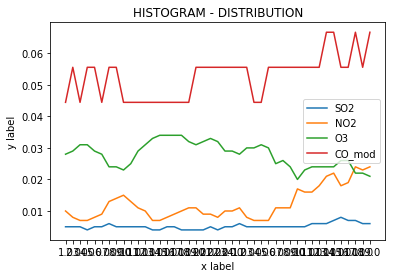

In [19]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod',]]
df_flip_x()
plt.show()

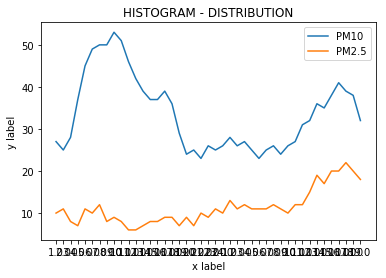

In [20]:
[df_plot(df[col]) for col in ['PM10', 'PM2.5']]
df_flip_x()
plt.show()

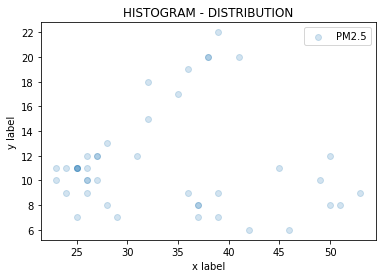

In [21]:
# 스케터는 플립이 필요없음!
df_scatter(df.PM10, df['PM2.5'])
plt.legend()

## 플립하지 말아야 할 그래프

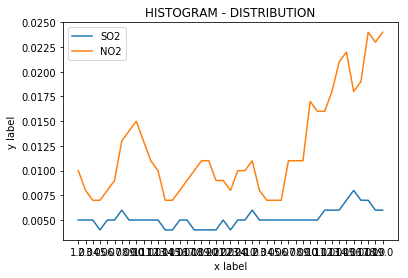

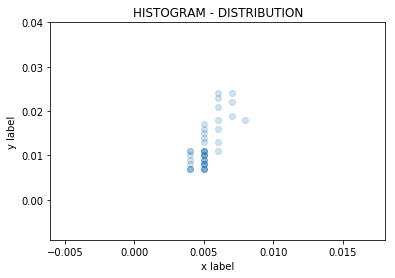

In [22]:
# 전체 플로팅 중에 관심사항만 따로 플로팅 해서 관찰하기
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]
# plt.show()

[df_plot(df[col]) for col in ['SO2', 'NO2']]
df_flip_x()           # x 좌표는 플립해야 함. / y좌표는 유지!
plt.show()

# 스캐터는 플립할 필요가 없음
df_scatter(df.SO2, df.NO2)
plt.show()

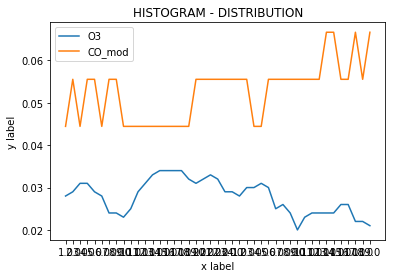

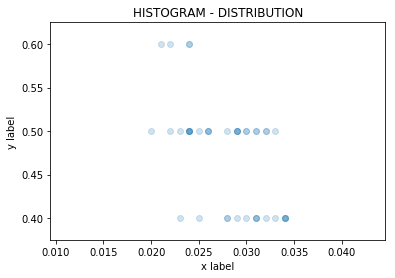

In [23]:
# 전체 플로팅 중에 관심사항만 따로 플로팅 해서 관찰하기
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]
# plt.show()

[df_plot(df[col]) for col in ['O3', 'CO_mod',]]
df_flip_x()           # x 좌표는 플립해야 함. / y좌표는 유지!
plt.show()

# 스캐터는 플립필요없음!
df_scatter(df.O3, df.CO)
plt.show()

[None, None, None, None, None, None]

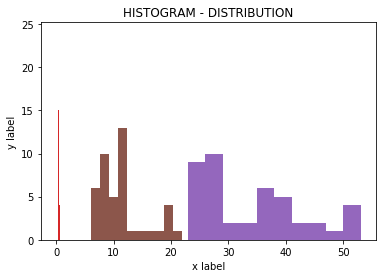

In [27]:
[df_hist(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]

> 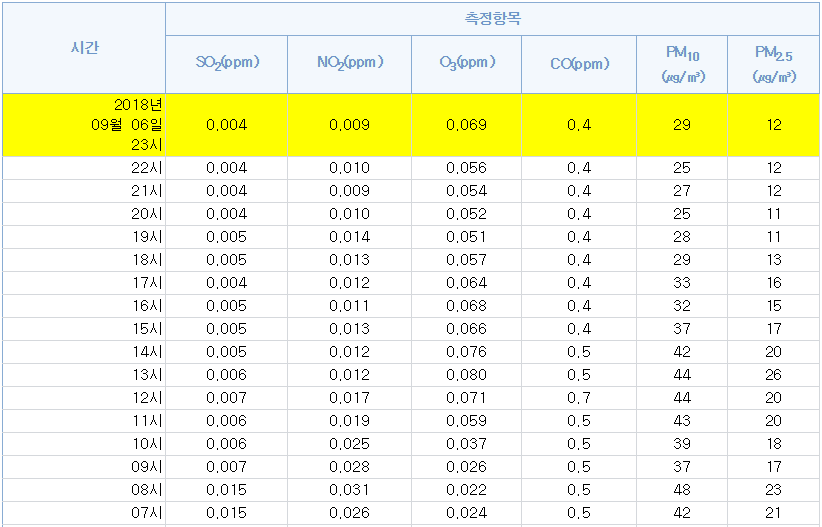

In [25]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
df.to_csv('air_incheon.csv', sep=',', encoding='utf-8')